In [1]:
import numpy as np
import pandas as pd
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import json
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import matthews_corrcoef

In [2]:
df = pd.read_csv('resp_data2.csv')
df.shape

(337393, 189)

### EDA

In [3]:
# df = df.drop_duplicates()

In [4]:
df=df.dropna()

In [5]:
df['target'] = np.where(df['Response'] == 0,0,1)

In [6]:
# Get the number of unique values in each column
unique_counts = df.nunique()

In [7]:
# Get the list of columns with only one unique value
single_unique_cols = unique_counts[unique_counts == 1].index.tolist()

# Drop columns with only one unique value
df = df.drop(columns=single_unique_cols)
df.shape

(337392, 183)

In [8]:
list(df.nunique())

[30,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 63473,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2]

In [9]:
# List the columns to remove
columns_to_remove = ['indiv_id', 'Response','OfferID']

# Drop the specified columns from the DataFrame
df.drop(columns=columns_to_remove, inplace=True)

In [10]:
df.shape

(337392, 180)

### Train and Test Splitting

In [11]:
# Splitting the dataset into X and y
X = df.drop('target', axis=1)  # Features: all columns except 'target'
y = df['target']

In [12]:
# # Convert all columns to categorical data type
# X = X.astype('category')
# X.shape

In [13]:
# # Splitting dataset into training and testing set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape,X_test.shape

In [14]:
# Split the dataset into 70% training and 30% temporary test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary test set into 50% test and 50% validation, which makes it 15% of the original dataset each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape,X_test.shape,X_val.shape

((236174, 179), (50609, 179), (50609, 179))

In [15]:
list(X.columns)

['os_103_ ',
 'os_103_20 Pct Off Living Room',
 'os_103_BBQ Party Time',
 'os_103_Black Friday Sale',
 'os_103_Bring More Light to Your Living Room and Save!',
 'os_103_Decorate Your Living Room!',
 'os_103_Eat well be well',
 'os_103_Featured Dressers',
 'os_103_Featured Furniture',
 'os_103_Fresh Catfish Fillets',
 'os_103_Fresh Cod Fillets',
 'os_103_Fresh Juice',
 'os_103_Fresh Walleye Fillets',
 'os_103_Garden Gloves',
 "os_103_Get Better Night's Rest!",
 'os_103_Get the Emerald Credit Card!',
 'os_103_Get the app!',
 'os_103_Get your beef on today',
 'os_103_Ironport - Fresh',
 'os_103_Modernize Your Living Room and Save!',
 'os_103_New Arrivals Beds',
 'os_103_New Arrivals Decor',
 'os_103_Organize Your Stuff and Save!',
 'os_103_Salmon',
 'os_103_Tailor made cap',
 'os_103_The right vitamins for you',
 'os_103_Turkey Time',
 'os_103_Vegan - burger',
 'os_104_ ',
 'os_104_10% off all modern style beds! Hurry, this deal will not last!',
 'os_104_10% off all modern style dressers!

In [16]:
categorical_features = ['os_103_ ',
 'os_103_20 Pct Off Living Room',
 'os_103_BBQ Party Time',
 'os_103_Black Friday Sale',
 'os_103_Bring More Light to Your Living Room and Save!',
 'os_103_Decorate Your Living Room!',
 'os_103_Eat well be well',
 'os_103_Featured Dressers',
 'os_103_Featured Furniture',
 'os_103_Fresh Catfish Fillets',
 'os_103_Fresh Cod Fillets',
 'os_103_Fresh Juice',
 'os_103_Fresh Walleye Fillets',
 'os_103_Garden Gloves',
 "os_103_Get Better Night's Rest!",
 'os_103_Get the Emerald Credit Card!',
 'os_103_Get the app!',
 'os_103_Get your beef on today',
 'os_103_Ironport - Fresh',
 'os_103_Modernize Your Living Room and Save!',
 'os_103_New Arrivals Beds',
 'os_103_New Arrivals Decor',
 'os_103_Organize Your Stuff and Save!',
 'os_103_Salmon',
 'os_103_Tailor made cap',
 'os_103_The right vitamins for you',
 'os_103_Turkey Time',
 'os_103_Vegan - burger',
 'os_104_ ',
 'os_104_10% off all modern style beds! Hurry, this deal will not last!',
 'os_104_10% off all modern style dressers! Hurry, this deal will not last!',
 'os_104_10% off all modern style lighting fixtures! Hurry, this deal will not last!',
 'os_104_10% off all modern style sofas! Hurry, this deal will not last!',
 'os_104_Apply for Emerald no annual fee Credit Card and start earning point and discounts toward your next purchase right away! right ',
 'os_104_BBQ meat and special sauces ready for kick-start your next party. Pork ribs $9.95 / LB Beef ribs $4.99 / LB Ground chuck $5.20 / LB Chicken legs $5.20 Order online or with the GeoFlex application and we delivery to your home. Purchase $50 or more and choose from our selection of specialty rubs and sauces at ½ price.',
 'os_104_Beautiful chairs, couches & tables that fit any decor',
 'os_104_Beyond Meat Plant Based Patties 8 OZ box $6.89 Available online or us the GeoFlex mobile app.  Find in store in the frozen food section',
 'os_104_Bring warmth and comfort to your living room with wide selection of decor items on sale!',
 'os_104_Customize this year’s stocking cap. Enter your design online and in the GeoFlex mobile app.  See our new section in store Kisok where you can customize the cap and have it shipped to you anywhere.',
 'os_104_Frozen Farm Fresh Walleye, 2 lb bag Now: $43.00 $21.50  LB Order online of with the GeoFlex mobile app and receive an additional $2 off Present this code – I LOVE Walleye  and get $1 off at the counter',
 'os_104_Frozen Raw Atlantic Cod Fillets, 2 lb bag Now: $9.96 $4.98/ LB Order online of with the GeoFlex mobile app and receive an additional $2 off  Present this code – I LOVE COD  and get $1 off at the counter',
 'os_104_Frozen Raw US Corn-Feed  Catfish Fillets, 4 lb bag Now: $29.94  $7.47/ LB Order online or with the GeoFlex mobile app and receive an additional $2 off  Present this code – I LOVE CATFISH and get $1 off at the counter',
 'os_104_Frozen Wild Alaskan King Salmon 6 – 4 Oz portions $93.95 Order online of with the GeoFlex mobile app and pick-up in-store to receive an additional $2 off  Present this code – I LOVE SAMON  and get $1 off at the counter',
 'os_104_Functional and space-saving beds to extend any sleeping space',
 'os_104_Grass fed beef and special cuts by our butchers to fit your  needs.  Ribeye: $18.90 LB Tenderloin $24.92 LB New York Strip $29.00 LB Pre-order online or with the GeoFlex application and we delivery to your home.  Ask our butcher to slice and trim to your specification. ',
 'os_104_Great savings this holiday season starting Nov 26',
 'os_104_Highly-functional dressers that maximize both storage space and function',
 'os_104_Living room for a limited time. Online only.',
 'os_104_Select the right type of vitamins for you. Capsules, chewable, and drinks. Order online or with the GeoFlex application for guidelines and recommendations based on age and personal needs.  Come in the store and use or new in-store health and well being Kisok.',
 'os_104_Select the right wellness recipe for your lifestyle. We box recipes based on your needs. Prices range from $5 – 25. Order online or with the GeoFlex application and we delivery to your home.  Come in the store and order from our Kisok and we will box up for you as you shop.',
 'os_104_Shop at the Emerald store on your smartphone!',
 'os_104_Stop by our Deli fountain and enjoy a fresh made Ironport. $3.50   Try our Ironport syrup and delight your guest. $19.00 / 1 GAL Come in the store stop by our Deli fountain.  Order the Ironport syrup online or with the GeoFlex application. We ship free for orders over $75',
 'os_104_Stop by our Deli fountain and enjoy a fresh pressed juices. Carrot, Peach, Apple $ 3.50  per glass  Come in the store stop by our Deli fountain.',
 'os_104_Touch screen sensitive Bamboo gloves are lightweight and durable. $9.99 Available online and in the GeoFlex mobile app. See our new section of gardening supplies and shop in-store. Order 1 and get the $1.50 off the second pare. ',
 'os_104_Versatile pieces to accent all your surfaces & walls',
 'os_104_We have the best smoked turkey ready for you. Sizes from 12 to 32 lbs.  / $4 LB Pre-order online or with the GeoFlex application and we delivery to your home.  Order in-store for future delivery date. In time for the holidays.',
 'os_105_ ',
 'os_105_Apply Now!',
 'os_105_Download Now!',
 'os_105_Go to GeoFlex mobile app',
 'os_105_Learn More',
 'os_105_Learn More!',
 'os_105_Shop Now!',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/07a2c216-2c59-4b9a-bcf6-388ea14069cc/renditions/e67613fa-06ad-4b9f-b0f5-00d168d1353b?binary=true&lastModified=1709761892860',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/29e6c22c-52d4-45b4-8453-561e936d7da5/renditions/1ecad6cb-4983-4595-ab82-afe345607c9d?thumbnail=true&lastModified=1709761892058',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/379fe39f-df00-45fe-9539-b835cceab621/renditions/93adb17b-d204-4eb0-aa26-f587d1f9b9d7?thumbnail=true&lastModified=1709761889184',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/37e899ad-90d5-48f0-bd1f-bd47cbb11a44/renditions/f69d36c8-8e3b-403b-8d48-ed08bfeb0f29?thumbnail=true&lastModified=1709761889206',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/415f8800-8436-48ca-9e25-d1636a33a37b/renditions/85b37065-1619-4328-b00a-ca346cc2b2d2?binary=true&lastModified=1709761888559',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/6464f7a6-fbb3-41a5-8ae9-6691e9f1353a/renditions/2ca84e19-5abf-4330-bbd5-d108cd8f62ac?thumbnail=true&lastModified=1709761889073',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/66e04abf-851e-43d5-b988-db6efc4a8c52/renditions/0990405d-00d9-404e-bad8-a90c43e54bff?thumbnail=true&lastModified=1709761894557',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/7872172a-8f8f-42bb-95cf-728fc58a4d20/renditions/09988c62-1438-4dfc-9470-be5546ef0ec4?binary=true&lastModified=1709761889138',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/832e0bf6-702a-4583-9772-ab140c54ff86/renditions/1f22ec10-764a-4a6b-a679-9e87a5937b14?thumbnail=true&lastModified=1709761892262',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/8c11daf5-14d6-4ed7-9463-3325322f1022/renditions/ec3f478e-4416-4d35-8335-47d3b55a3709?thumbnail=true&lastModified=1709761888690',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/b47151a8-56c2-480d-92be-95d2572c3e80/renditions/96045300-9688-4711-bf88-6df4758278b2?thumbnail=true&lastModified=1709761894570',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/b9fc8389-9bba-40a7-b5a1-e62db81fcb41/renditions/1146eca0-314e-40c8-92ef-42c95ca903d1?binary=true&lastModified=1709761892459',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/f7ebd9b4-04ee-4588-8253-9733364807dd/renditions/6e0bbf7c-6e32-4bd6-970c-fb117ae0d831?thumbnail=true&lastModified=1709761894668',
 'os_106_https://dx.sbx0094.play.hclsofy.com/dx/api/dam/v1/collections/16366735-10b9-4a07-884c-ced46b548f36/items/fd1337d9-053a-4b26-996e-e69fd45fd420/renditions/997f99b6-e684-4594-9eba-01e513fcefef?thumbnail=true&lastModified=1709761889098',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Bedroom.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Black_Friday.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Credit_Card.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Decorating.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Dressers.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Gift.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_LR_Decor.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_LR_Furniture.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Living_Room.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/Emerald_Mobile_App.png',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/emerald/bedroom/beds/bed2_a1_350.jpg',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/emerald/bedroom/dressers/beddress3_a1_350.jpg',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/emerald/livingroom/decoration/rug3_a1_350.jpg',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/emerald/livingroom/furniture/couch1_a1_350.jpg',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/emerald/livingroom/lighting/light6_a1_350.jpg',
 'os_106_https://unicacx-demo-1.hcltechsw.com/images/furniture_sale_40.png',
 'os_108_ EAST',
 'os_108_ NCEN',
 'os_108_ TOLA',
 'os_108_ WEST',
 'os_108_ tags',
 'os_108_EAST',
 'os_108_NCEN',
 'os_108_Subject: Retail, Keyword: Bedrooms, Keyword: New Arrival, Sentiment: neutral',
 'os_108_Subject: Retail, Keyword: New Arrival, Sentiment: positive',
 'os_108_Subject: Undetermined, Keyword: Bedrooms, Keyword: Style, Sentiment: positive',
 'os_108_Subject: Undetermined, Keyword: Choice, Keyword: Comfort, Sentiment: positive',
 'os_108_Subject: Undetermined, Keyword: Holiday, Keyword: Savings, Keyword: Season, Bucket: Days of the Week [Friday] [Tag: Savings] savings: Friday, Bucket: Days of the Week [Friday] [Tag: Season] season: Friday, Bucket: Holidays [US-->Black Friday] [Tag: Savings] savings: Black Friday, Bucket: Holidays [US-->Black Friday] [Tag: Season] season: Black Friday, Sentiment: positive',
 'os_108_Subject: Undetermined, Keyword: Limited Time, Keyword: Online Offer, Image: Couch, Image: Cushion, Image: Furniture, Image: Home Decor, Image: Indoors, Image: Living Room, Image: Room, Sentiment: negative',
 'os_108_Subject: Undetermined, Keyword: Style, Bucket: Product [Site-->Apparel-->Women-->Dress] [Tag: All] all: dressers, Bucket: Product [Site-->Apparel-->Women-->Dress] [Tag: Discount] off: dressers, Bucket: Product [Site-->Apparel-->Women-->Dress] [Tag: Life Style] stylesers: dressers, Bucket: Product [Site-->Apparel-->Women-->Dress] [Tag: Style] stylesers: dressers, Sentiment: positive',
 'os_108_Subject: Undetermined, Keyword: Style, Sentiment: positive',
 'os_108_Subject: Undetermined, Sentiment: positive',
 'os_108_TOLA',
 'os_109_Beef',
 'os_109_Clothing',
 'os_109_Digital media',
 'os_109_Emerald',
 'os_109_Fish',
 'os_109_Frozen meals',
 'os_109_Health care',
 'os_109_Juices',
 'os_109_Prepared meals',
 'os_109_Soft drinks',
 'os_109_bed',
 'os_109_decor',
 'os_109_dresser',
 'os_109_furniture',
 'os_109_lighting',
 'os_109_living room',
 'os_109_sofa',
 'os_110_1',
 'os_110_2',
 'os_111_Brand',
 'os_111_Clothing',
 'os_111_Cold drinks',
 'os_111_Deli',
 'os_111_Frozen foods',
 'os_111_Health and beauty',
 'os_111_Health foods',
 'os_111_Home and garden',
 'os_111_Meat',
 'os_111_Seafood',
 'os_111_bedroom',
 'os_111_decor',
 'os_111_furniture',
 'os_112_ ',
 'os_112_ 1',
 's_239_7',
 's_239_8',
 's_239_9',
 's_239_10',
 's_241_11',
 's_241_12',
 's_241_13',
 's_241_14',
 's_241_15',
 's_241_16',
 's_258_36',
 's_258_37',
 's_258_38',
 's_258_39',
 's_241_67',
 's_241_68',
 's_241_69',
 's_248_70',
 's_247_71',
 's_248_72',
 's_247_73',
 's_248_74',
 's_247_75',
 's_248_76',
 's_247_77',
 's_247_78',
 's_305_87',
 's_305_88',
 's_305_89',
 's_306_90',
 's_306_91',
 's_306_92',
 'ContactMonth',
 'CantactDayOfMonth',
 'ContactHour']

In [17]:
for feature in categorical_features:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    X_val[feature] = X_val[feature].astype(str)

In [18]:
categorical_features

['os_103_ ',
 'os_103_20 Pct Off Living Room',
 'os_103_BBQ Party Time',
 'os_103_Black Friday Sale',
 'os_103_Bring More Light to Your Living Room and Save!',
 'os_103_Decorate Your Living Room!',
 'os_103_Eat well be well',
 'os_103_Featured Dressers',
 'os_103_Featured Furniture',
 'os_103_Fresh Catfish Fillets',
 'os_103_Fresh Cod Fillets',
 'os_103_Fresh Juice',
 'os_103_Fresh Walleye Fillets',
 'os_103_Garden Gloves',
 "os_103_Get Better Night's Rest!",
 'os_103_Get the Emerald Credit Card!',
 'os_103_Get the app!',
 'os_103_Get your beef on today',
 'os_103_Ironport - Fresh',
 'os_103_Modernize Your Living Room and Save!',
 'os_103_New Arrivals Beds',
 'os_103_New Arrivals Decor',
 'os_103_Organize Your Stuff and Save!',
 'os_103_Salmon',
 'os_103_Tailor made cap',
 'os_103_The right vitamins for you',
 'os_103_Turkey Time',
 'os_103_Vegan - burger',
 'os_104_ ',
 'os_104_10% off all modern style beds! Hurry, this deal will not last!',
 'os_104_10% off all modern style dressers!

In [19]:
pool = Pool(X_train, y_train, cat_features=categorical_features, feature_names=list(X.columns))

### Modelling

In [20]:
catboost_model = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.01,
    reg_lambda=4.399746830522444,
    eval_metric='Logloss',
    max_depth = 10,
    colsample_bylevel = 0.945675624269418,
    random_strength = 2.104135746865191,
    random_state = 42,
    bootstrap_type = 'Bayesian',
    bagging_temperature= 4.428918024504635,
    auto_class_weights = 'Balanced'
    )

catboost_model.fit(pool,eval_set = [(X_test, y_test)], use_best_model=True, early_stopping_rounds=50)

0:	learn: 0.6845192	test: 0.6846329	best: 0.6846329 (0)	total: 166ms	remaining: 2m 46s
1:	learn: 0.6751323	test: 0.6753641	best: 0.6753641 (1)	total: 263ms	remaining: 2m 11s
2:	learn: 0.6668869	test: 0.6672261	best: 0.6672261 (2)	total: 351ms	remaining: 1m 56s
3:	learn: 0.6588061	test: 0.6592691	best: 0.6592691 (3)	total: 443ms	remaining: 1m 50s
4:	learn: 0.6513248	test: 0.6518837	best: 0.6518837 (4)	total: 532ms	remaining: 1m 45s
5:	learn: 0.6442398	test: 0.6449143	best: 0.6449143 (5)	total: 618ms	remaining: 1m 42s
6:	learn: 0.6375859	test: 0.6383662	best: 0.6383662 (6)	total: 706ms	remaining: 1m 40s
7:	learn: 0.6310092	test: 0.6319014	best: 0.6319014 (7)	total: 800ms	remaining: 1m 39s
8:	learn: 0.6246934	test: 0.6256782	best: 0.6256782 (8)	total: 889ms	remaining: 1m 37s
9:	learn: 0.6185271	test: 0.6196153	best: 0.6196153 (9)	total: 986ms	remaining: 1m 37s
10:	learn: 0.6130280	test: 0.6142345	best: 0.6142345 (10)	total: 1.08s	remaining: 1m 36s
11:	learn: 0.6077081	test: 0.6090081	best

In [21]:
y_pred_test = catboost_model.predict(X_test)
y_pred_train = catboost_model.predict(X_train)
y_pred_val = catboost_model.predict(X_val)

## Feature impotance

In [22]:
feature_importance = catboost_model.feature_importances_

In [23]:
# Create a DataFrame with feature names and importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_model.feature_importances_
})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [24]:
feature_importance_df[:20]

,Feature,Importance
59,os_105_Go to GeoFlex mobile app,43.910548
178,ContactHour,16.709652
177,CantactDayOfMonth,16.503791
176,ContactMonth,13.952868
162,s_247_71,0.965025
165,s_248_74,0.662292
174,s_306_91,0.527854
168,s_247_77,0.480554
159,s_241_68,0.445277
163,s_248_72,0.442290


In [25]:
feature_importance_df[:20].sum()

Feature       os_105_Go to GeoFlex mobile appContactHourCant...
Importance                                            97.643154
dtype: object

In [26]:
feature_importance_df.to_csv('top_70.csv')

In [102]:
list(feature_importance_df['Feature'][:20])

['os_105_Go to GeoFlex mobile app',
 'ContactHour',
 'CantactDayOfMonth',
 'ContactMonth',
 's_247_71',
 's_248_74',
 's_247_75',
 's_248_72',
 's_306_91',
 's_247_77',
 's_258_37',
 's_306_90',
 's_247_73',
 's_241_68',
 'os_108_EAST',
 's_305_88',
 's_241_15',
 's_239_7',
 's_258_39',
 's_258_36']

## IV & COR

In [27]:
import numpy as np
import pandas as pd
np.random.seed(100)

iv_results = []
# Define your target column
target = 'target'

# Loop over each feature column
for feature in df.columns:
    # Skip the target column
    if feature == target:
        continue
    
    # Calculate correlation between feature and target
    correlation = df[feature].corr(df[target])
    
    # Calculate WoE and IV
    df_woe_iv = (pd.crosstab(df[feature], df[target], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe'] * (dfx[1] - dfx[0]))))
    
    # Compute IV
    iv = df_woe_iv['iv'].iloc[0]  # Assuming there's only one unique value for each feature
    
    # Append feature, IV, and correlation to results list
    iv_results.append({'Feature': feature, 'IV': iv, 'Correlation': correlation})

# Convert the results list to a DataFrame
iv_results_df = pd.DataFrame(iv_results)

# Sort results by IV in descending order
iv_results_df = iv_results_df.sort_values(by='IV', ascending=False)

iv_results_df

/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/azureuser/.local/lib/python3.10/site-packages/pandas/core/arraylike.p

,Feature,IV,Correlation
0,os_103_,inf,-0.105900
101,"os_108_Subject: Retail, Keyword: New Arrival, ...",inf,-0.027068
97,os_108_ tags,inf,-0.168048
92,os_106_https://unicacx-demo-1.hcltechsw.com/im...,inf,-0.105900
91,os_106_https://unicacx-demo-1.hcltechsw.com/im...,inf,-0.027902
...,...,...,...
153,s_241_16,0.000078,0.002401
161,s_248_70,0.000029,0.001461
175,s_306_92,0.000026,-0.001360
165,s_248_74,0.000016,0.001085


In [28]:
iv_results_df.to_csv('IV_corelation.csv',index=False)

In [58]:
y_pred_train = catboost_model.predict_proba(X_train)[:,1] > 0.674
y_pred_test = catboost_model.predict_proba(X_test)[:,1] > 0.674
y_pred_val = catboost_model.predict_proba(X_val)[:,1] > 0.674

### Train

In [109]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 99928 117408]
 [    42  18796]]


In [110]:
# Evaluating the model
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on trn set: {accuracy}")

Accuracy on trn set: 0.5026971639553888


In [111]:
# Evaluating the model
f1 = f1_score(y_train, y_pred_train)
print(f"f1 on train set: {f1}")

f1 on train set: 0.2424633325163504


In [112]:
# Evaluating the model
f1 = f1_score(y_train, y_pred_train,average='weighted')
print(f"f1 on train set: {f1}")

f1 on train set: 0.5989531561543203


In [113]:
matthews_corrcoef(y_train, y_pred_train)

0.250898422292741

### TEST

In [64]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[41460  5132]
 [ 2524  1493]]


In [65]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.8487225592285957


In [66]:
# Evaluating the model
f1 = f1_score(y_test, y_pred_test)
print(f"f1 on test set: {f1}")

f1 on test set: 0.28058635594813003


In [67]:
# Evaluating the model
f1 = f1_score(y_test, y_pred_test,average='weighted')
print(f"f1 on test set: {f1}")

f1 on test set: 0.8650811886464929


In [68]:
matthews_corrcoef(y_test, y_pred_test)

0.2095925014866278

### Validation

In [69]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[41564  5084]
 [ 2492  1469]]


In [70]:
# Evaluating the model
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy on val set: {accuracy}")

Accuracy on val set: 0.8503033057361339


In [71]:
# Evaluating the model
f1 = f1_score(y_val, y_pred_val)
print(f"f1 on val set: {f1}")

f1 on val set: 0.27943694122122886


In [72]:
# Evaluating the model
f1 = f1_score(y_val, y_pred_val,average='weighted')
print(f"f1 on val set: {f1}")

f1 on val set: 0.866616650426805


In [73]:
matthews_corrcoef(y_val, y_pred_val)

0.20950664789289894

## parameter tunning

In [37]:
# def objective(trial):
#     params = {
#         "iterations":500,
#         #"logging_level":'silent',
#         #"verbose":0,
#         "learning_rate": 0.01,
#         "max_depth": trial.suggest_int("max_depth", 3,10),
#         # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20,100),
#         "random_state": 42,
#         # "subsample": trial.suggest_uniform('subsample', 0.5, 1.0),
#         "reg_lambda": trial.suggest_float('reg_lambda', 0.1, 5.0),
#         "colsample_bylevel": trial.suggest_float('colsample_bylevel', 0.3, 1.0),
#         "random_strength": trial.suggest_float("random_strength", 1, 10.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.2, 5.0),
#         "bootstrap_type": 'Bayesian',
#         "eval_metric":'Logloss',
#         "auto_class_weights":'Balanced'
#     }

#     model = catboost.CatBoostClassifier(**params, silent=True)
#     # model.fit(X_train, y_train)
#     model.fit(pool)
#     # y_pred_test = model.predict_proba(X_test)
#     y_pred_val = model.predict(X_val)
#     f1 = f1_score(y_val, y_pred_val)
#     return f1

# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction='maximize',sampler=sampler)
# study.optimize(objective, n_trials=200)

# print('Best hyperparameters:', study.best_params)
# print('Best F1:', study.best_value)

[I 2024-04-30 08:58:19,331] A new study created in memory with name: no-name-14367e1c-6bc2-43aa-aba1-d4adb013fb42
[I 2024-04-30 08:58:34,910] Trial 0 finished with value: 0.23439950291445985 and parameters: {'max_depth': 5, 'reg_lambda': 4.758500101408589, 'colsample_bylevel': 0.8123957592679836, 'random_strength': 6.387926357773329, 'bagging_temperature': 0.9488894741236953}. Best is trial 0 with value: 0.23439950291445985.
[I 2024-04-30 08:58:49,204] Trial 1 finished with value: 0.23439950291445985 and parameters: {'max_depth': 4, 'reg_lambda': 0.38460969962417735, 'colsample_bylevel': 0.9063233020424546, 'random_strength': 6.41003510568888, 'bagging_temperature': 3.5987483734210186}. Best is trial 0 with value: 0.23439950291445985.
[I 2024-04-30 08:59:02,920] Trial 2 finished with value: 0.23439950291445985 and parameters: {'max_depth': 3, 'reg_lambda': 4.852558275593772, 'colsample_bylevel': 0.8827098485602951, 'random_strength': 2.9110519961044856, 'bagging_temperature': 1.0727598

Best hyperparameters: {'max_depth': 10, 'reg_lambda': 4.399746830522444, 'colsample_bylevel': 0.945675624269418, 'random_strength': 2.104135746865191, 'bagging_temperature': 4.428918024504635}
Best F1: 0.2366532146267829


In [38]:
# import pickle
# # Save the object as a pickle file
# with open('study_new.pkl', 'wb') as file:
#     pickle.dump(study, file)

### JSON Format

In [ ]:
# catboost_model.save_model(
#     "catboost_model.json",
#     format="json",
#     pool=pool  # this parameter is required only for models with categorical features.
# )

In [ ]:
# catboost_model.plot_tree(
#     tree_idx=0,
#     pool=pool
# )

In [56]:
# Predict probabilities for the positive class
y_prob_test = catboost_model.predict_proba(X_test)[:, 1]
y_prob_train = catboost_model.predict_proba(X_train)[:, 1]
y_prob_val = catboost_model.predict_proba(X_val)[:, 1]

In [57]:
# Calculate F1 scores for different threshold values
threshold_values = np.arange(0, 1.0, 0.001)
f1_scores = []
for threshold in threshold_values:
    y_pred_threshold = (y_prob_test > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Find the threshold value with the highest F1 score
best_threshold = threshold_values[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: 0.674
Best F1 Score: 0.28058635594813003


In [74]:
# Calculate Youden index for different threshold values
threshold_values = np.arange(0, 1.0, 0.001)
youden_scores = []
for threshold in threshold_values:
    y_pred_threshold = (y_prob_test > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1
    youden_scores.append(youden_index)

# Find the threshold value with the highest Youden index
best_threshold = threshold_values[np.argmax(youden_scores)]
best_youden_index = np.max(youden_scores)

print("Best Threshold (Youden Cut-off):", best_threshold)
print("Best Youden Index:", best_youden_index)


Best Threshold (Youden Cut-off): 0.368
Best Youden Index: 0.4408998919769551


In [75]:
import numpy as np
from sklearn.metrics import roc_curve

# Assuming y_test and y_prob_test are your true labels and predicted probabilities, respectively
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# Calculate Youden's index for each threshold
youden_index = tpr - fpr

# Find the optimal threshold that maximizes Youden's index
optimal_threshold = thresholds[np.argmax(youden_index)]

# Print the optimal threshold and corresponding Youden's index
print("Optimal Cut-Off Probability:", optimal_threshold)
print("Youden's Index:", np.max(youden_index))


Optimal Cut-Off Probability: 0.36900610235019216
Youden's Index: 0.440899891976955


Optimal Cut-Off Probability: 0.36900610235019216
Youden's Index: 0.440899891976955


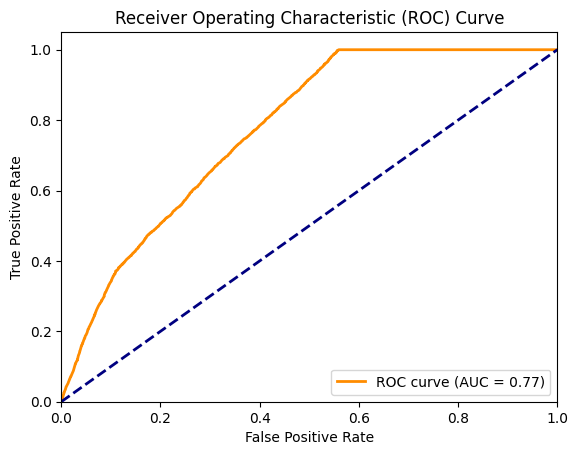

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_prob_test are your true labels and predicted probabilities, respectively
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Calculate Youden's index for each threshold
youden_index = tpr - fpr

# Find the optimal threshold that maximizes Youden's index
optimal_threshold = thresholds[np.argmax(youden_index)]

# Print the optimal threshold and corresponding Youden's index
print("Optimal Cut-Off Probability:", optimal_threshold)
print("Youden's Index:", np.max(youden_index))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [77]:
# Assuming `y_prob` contains the predicted probabilities from your model
youden_threshold = 0.440899891976955  # the Youden's Index optimal cut-off you calculated

# Apply threshold to the probability scores to make class predictions
y_pred_train = (y_prob_train > youden_threshold).astype(int)
y_pred_test = (y_prob_test > youden_threshold).astype(int)
y_pred_val = (y_prob_val > youden_threshold).astype(int)

In [82]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)
mcc= matthews_corrcoef(y_test, y_pred_test)

In [83]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(cm)
print(mcc)

Accuracy: 0.4885692268173645
F1 Score: 0.23570057581573897
[[20735 25857]
 [   26  3991]]
0.24102097505848213


In [84]:
# Calculate metrics
accuracy = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
cm = confusion_matrix(y_train, y_pred_train)
mcc= matthews_corrcoef(y_train, y_pred_train)

In [85]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(cm)
print(mcc)

Accuracy: 0.4942457679507482
F1 Score: 0.23973980345231427
[[ 97895 119441]
 [     5  18833]]
0.24756798143004055


In [86]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
cm = confusion_matrix(y_val, y_pred_val)
mcc= matthews_corrcoef(y_val, y_pred_val)

In [87]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(cm)
print(mcc)

Accuracy: 0.4924618150921773
F1 Score: 0.23467016268398785
[[20985 25663]
 [   23  3938]]
0.2420511345171581
